# Overview

**GENERAL THOUGHTS:**  
The MulticlassTabularCatEmbeddingMLP is an advanced multi-layer perceptron (MLP) model tailored for multiclass classification tasks on tabular data, with a specific focus on handling both continuous and categorical features through embedding layers. The model integrates embeddings for categorical variables to efficiently represent high-cardinality features and combines them with continuous features using normalization techniques.
This Notebook contains an implementation of a MulticlassTabularCatEmbeddingMLP using PyTorch Lightning including hyper-parameter optimization with Optuna on a real world tabular dataset. It is an extension of the notebook [20_clf_pipeline_pytorch_MLP.ipynb](https://github.com/tiefenthaler/ml_packaging_classification/blob/main/notebooks/20_clf_pipeline_pytorch_MLP.ipynb).  
For more general details about PyTorch Lightning look at the [README_PyTorchLightning.MD](https://github.com/tiefenthaler/ml_packaging_classification/blob/main/README_PyTorchLightning.MD) (extensive tutorial of using pytorch lightning with tabular data for multi-class classification).  
For more information about the use case look at the [README.MD](https://github.com/tiefenthaler/ml_packaging_classification/blob/main/README.md).


**DATA PREPROCESSING:**  
Imbalanced data:
- over_sampling for imbalanced data.
- cost-sensitive learning for imbalanced data.

continuous data:
- Impute missing data: SimpleImputer(strategy='median').
- Standardize data: StandardScaler().

categorical data:
- Impute missing data: SimpleImputer(strategy='most_frequent').
- Ordinal & Nominal data encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).
- Unknown values ecoding and reordering of ordinal encoding: custom encoder "OrdinalEncoderExtensionUnknowns()".

target data:
- target encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

utility functions:
- check_data_consitancy
- check_dataloader_output
- print_dataloader_output
- print_model_summary
- plot_training_metrics

**MULTI-CLASS CLASSIFIER:**  
- Overview models to be considered:  
  - [X] Neural Net: MLP with categorical variable embedding (embMLP).
    - Using a heuristic for the embedding size of the categorical variables.
    - Learning rate optimization.
    - Callbacks: ValPercentageEarlyStopping.
    - Logging and evaluation of training and validation loss.
    - prediction on test set for evaluation based on classification report.

**FINAL MODEL PERFORMANCE:**  
- Evaluation of the model based on classification report on test data.

**Configurations for running the notebook**  
Set the following configurations befor running the notebook under the section [OVERVIEW](#overview):
- Infrastructure to run the notebook on, set ```compute``` to: local, colab, cloud (azure)
- Provide related directory config.yml file for your infrastructure:
  - project_directory
  - data_directory (source data)
  - lightning_exp_storage_directory
- General settings for experiments (SEED, data_samples)

In [ ]:
# NOTE: Configure the compute target. The NB handles realted configs. Options supported in this NB:
#       Run on local machine, set "compute" to: None
#       Run in google colab, set "compute" to: "colab"
#       Run on azure compute instanze within ML Service, set "compute" to: "azure"
from typing import Literal

compute: Literal[None, "colab", "azure"] = None  # Dafault None

In [ ]:
if compute == "colab":
    # Import the library to mount Google Drive
    from google.colab import drive
    # Mount the Google Drive at /content/drive
    drive.mount('/content/drive')
    # Verify by listing the files in the drive
    # !ls /content/drive/My\ Drive/
    # current dir in colab
    !pwd

In [ ]:
if compute == "colab":
    !pip install --upgrade optuna==3.5.0
    # !pip install --upgrade optuna.integration
    !pip install --upgrade mlflow
    !pip install --upgrade PyCaret

In [ ]:
import sys
import yaml

from typing import Dict, Iterable, List, Optional, Tuple, Union, Literal

import pandas as pd
from sklearn.metrics import classification_report

import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.tuner import Tuner
import torch
from torch import nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score

# ignore warnings
import warnings

warnings.filterwarnings("ignore")

In [ ]:
# get config
if compute == "colab":
    env_file = "./env_vars_colab.yml"
elif compute == "azure":
    env_file = "../env_vars_azureml_compute.yml"
else:
    env_file = "../env_vars.yml"
# NOTE: if used in Google Colab, upload env_vars_colab.yml to the current Google Colab directory.
try:
    with open(env_file, "r") as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print(f"Error: {env_file} not found.")
    if compute == "colab":
        print("Please upload it to the current Google Colab directory.")

# custom imports of local modules
sys.path.append(config["project_directory"])

from src.tabular_lightning.tabular_lightning import (
    TabularDataModuleClassificationPACKAGING,
    MulticlassTabularLightningModule,
)
from src.tabular_lightning.callbacks import ValPercentageEarlyStopping
from src.tabular_lightning import tabular_lightning_utils as tl_utils

In [ ]:
SEED = 42  # Ensure same data split as in other notebooks

# Load and Pre-process Data

In [ ]:
dm = TabularDataModuleClassificationPACKAGING(
    data_dir=f"{config['data_directory']}/output/df_ml.csv",
    continuous_cols=["material_weight"],
    categorical_cols=[
        "material_number",
        "brand",
        "product_area",
        "core_segment",
        "component",
        "manufactoring_location",
        "characteristic_value",
        "packaging_code",
    ],
    target=["packaging_category"],
    oversampling=True,
    test_size=0.2,
    val_size=0.2,
    batch_size=64,
    SEED=SEED,
)

In [ ]:
# NOTE: Run dm.prepare_data() and dm.setup() to get information from the dataset to build the model.
dm.prepare_data()
dm.setup(stage="fit")
# dm.data.info()
# dm.data.head()

In [34]:
dm.train_dataset.get_dataframe.head(5)

,material_weight,material_number,brand,product_area,core_segment,component,manufactoring_location,characteristic_value,packaging_code,packaging_category
0,-0.014936,2435,6,2,13,8421,17,282,35,1
1,-0.015001,10594,6,2,20,8355,17,282,33,22
2,-0.014273,6018,3,2,17,91,13,353,57,26
3,-0.015043,18002,2,3,3,12257,11,291,86,0
4,-0.015105,5511,2,1,8,4312,11,291,58,13


In [35]:
tl_utils.check_data_consitancy(dm)

In [36]:
tl_utils.check_dataloader_output(dm, next(iter(dm.train_dataloader())))

In [37]:
tl_utils.print_dataloader_output(dm)

Batch: 0
continuous torch.Size([64, 1])
categorical torch.Size([64, 8])
target torch.Size([64, 1])
Shape of network input: torch.Size([64, 9]) Data Types Cont: [torch.float32] Data Types Cat: [torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64]
Shape of target flatten: torch.Size([64, 1]) Data Types: torch.int64
Target from current batch: tensor([[ 1],
        [ 8],
        [20],
        [ 1],
        [17]])
Dataloader output from current batch, Cont: tensor([[-0.0149],
        [ 0.0117],
        [-0.0151]])
Dataloader output from current batch, Cat: tensor([[ 2292,     2,     2,    20,  4556,    17,   426,    63],
        [12752,     2,     4,     4,  5042,    12,   153,    31],
        [ 3059,     5,     4,     4,  9441,    12,   330,   109]])
Batch: 1


# Embedding MLP Model Definition

In [ ]:
tabular_data_full = pd.concat(
    [dm.train_dataset.get_dataframe, dm.val_dataset.get_dataframe, dm.test_dataset.get_dataframe],
    axis=0,
    ignore_index=True,
)
embedding_sizes_cat_features = tl_utils.get_cat_feature_embedding_sizes(
    tabular_data_full, categorical_cols=dm.categorical_cols
)
embedding_sizes_cat_features

{'material_number': (22537, 100),
 'brand': (11, 6),
 'product_area': (6, 4),
 'core_segment': (23, 9),
 'component': (12359, 100),
 'manufactoring_location': (24, 9),
 'characteristic_value': (473, 50),
 'packaging_code': (128, 24)}

In [39]:
tl_utils.print_embbeding_input_output(dm)

Batch: 0
continuous torch.Size([64, 1])
categorical torch.Size([64, 8])
target torch.Size([64, 1])
Data Types Cont: [torch.float32] Data Types Cat: [torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64, torch.int64]
Shape of target flatten: torch.Size([64, 1]) Data Types: torch.int64
Dataloader output from current batch, Cont:
 tensor([[-0.0150],
        [-0.0149],
        [-0.0151]])
Dataloader output from current batch, Cat:
 tensor([[ 4395,    10,     1,    11, 11777,    12,   182,   106],
        [17143,     2,     1,     8,  1460,    11,   301,    11],
        [  875,     2,     5,    21, 11577,     3,   461,    59]])
material_number - Min, Max:  tensor(241) tensor(21709)
brand - Min, Max:  tensor(2) tensor(10)
product_area - Min, Max:  tensor(1) tensor(5)
core_segment - Min, Max:  tensor(3) tensor(22)
component - Min, Max:  tensor(30) tensor(12318)
manufactoring_location - Min, Max:  tensor(3) tensor(17)
characteristic_value - Min, Max:  tenso

In [ ]:
class MulticlassTabularCatEmbeddingMLP(nn.Module):
    def __init__(
        self,
        continuous_cols: List[str] = None,
        categorical_cols: List[str] = None,
        output_size: int = None,
        # embedding_dim: int = None,
        hidden_size: int = None,
        n_hidden_layers: int = None,
        activation_class: nn.Module = nn.ReLU,
        dropout: float = None,
        norm: bool = True,
        embedding_sizes: Dict[str, Tuple[int, int]] = None,
    ) -> None:
        """Embedding Multi Layer Perceptron (embMLP) with embedding for categorical features for multiclass classification for tabular data.
        Args:
            continues_cols (List[str]): order of continuous variables in tensor passed to forward function.
            categorical_cols (List[str]): order of categorical variables in tensor passed to forward function.
            output_size (int): Number of output classes.
            hidden_size (int): Number of neurons in hidden layers.
            n_hidden_layers (int): Number of hidden layers.
            activation_class (nn.Module): Activation function.
            dropout (float): Dropout rate.
            norm (bool): Whether to use layer normalization.
            embedding_sizes (Dict[str, Tuple[int, int]]): Dictionary of embedding sizes for each categorical feature.
        """
        super().__init__()
        self.continuous_cols = continuous_cols
        self.categorical_cols = categorical_cols
        self.output_size = output_size
        self.embedding_sizes = embedding_sizes
        # self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.n_hidden_layers = n_hidden_layers
        self.activation_class = activation_class
        self.dropout = dropout
        self.norm = norm

        ### define the Embedding MLP ###
        ## embedding layers
        # cont featurres
        self.cont_normalizing = nn.BatchNorm1d(len(self.continuous_cols))
        # cat features
        self.cat_embeddings = nn.ModuleDict()
        for name in embedding_sizes.keys():
            self.cat_embeddings[name] = nn.Embedding(
                embedding_sizes[name][0],
                embedding_sizes[name][1],
            )
        ## input layer mlp
        mlp_input_size = sum(value[1] for value in embedding_sizes.values()) + len(
            self.continuous_cols
        )
        module_list = [nn.Linear(mlp_input_size, hidden_size), activation_class()]
        if dropout is not None:
            module_list.append(nn.Dropout(dropout))
        if norm:
            module_list.append(nn.LayerNorm(hidden_size))
        ## hidden layers
        for _ in range(n_hidden_layers):
            module_list.extend([nn.Linear(hidden_size, hidden_size), activation_class()])
            if dropout is not None:
                module_list.append(nn.Dropout(dropout))
            if norm:
                module_list.append(nn.LayerNorm(hidden_size))
        ## output layer
        module_list.append(nn.Linear(hidden_size, output_size))

        self.mlp_layers = nn.Sequential(*module_list)

    def forward(self, x: Dict[str, torch.Tensor]) -> torch.Tensor:
        """Forward pass through the embMLP."""

        assert (
            "continuous" in x or "categorical" in x
        ), "x must contain either continuous or categorical features"

        ### forward embedding layers ###
        # cont features
        if len(self.continuous_cols) > 0:
            embed_vector_cont = self.cont_normalizing(x["continuous"])
        else:
            embed_vector_cont = x["continuous"]
        # cat features
        if len(self.categorical_cols) > 0:
            output_vectors = {}
            for idx, (name, emb) in enumerate(self.cat_embeddings.items()):
                output_vectors[name] = emb(x["categorical"][:, idx])
            embed_vector_cat = torch.cat(list(output_vectors.values()), dim=1)
        # output_vector_embed
        if embed_vector_cont is None:
            output_vector_embed = embed_vector_cat
        else:
            output_vector_embed = torch.cat([embed_vector_cont, embed_vector_cat], dim=1)

        ### forward hidden layers ###
        return self.mlp_layers(output_vector_embed)

In [ ]:
# NOTE: Run dm.prepare_data() and dm.setup() to get information from the dataset to build your model.
multiclass_embMLP = MulticlassTabularCatEmbeddingMLP(
    continuous_cols=dm.continuous_cols,
    categorical_cols=dm.categorical_cols,
    output_size=dm.n_classes,
    hidden_size=64,
    n_hidden_layers=3,
    dropout=0.2,
    norm=True,
    embedding_sizes=embedding_sizes_cat_features,
)

In [42]:
tl_utils.print_model_summary(multiclass_embMLP)

Parameter name: cont_normalizing.weight, Shape: torch.Size([1])
Parameter name: cont_normalizing.bias, Shape: torch.Size([1])
Parameter name: cat_embeddings.material_number.weight, Shape: torch.Size([22537, 100])
Parameter name: cat_embeddings.brand.weight, Shape: torch.Size([11, 6])
Parameter name: cat_embeddings.product_area.weight, Shape: torch.Size([6, 4])
Parameter name: cat_embeddings.core_segment.weight, Shape: torch.Size([23, 9])
Parameter name: cat_embeddings.component.weight, Shape: torch.Size([12359, 100])
Parameter name: cat_embeddings.manufactoring_location.weight, Shape: torch.Size([24, 9])
Parameter name: cat_embeddings.characteristic_value.weight, Shape: torch.Size([473, 50])
Parameter name: cat_embeddings.packaging_code.weight, Shape: torch.Size([128, 24])
Parameter name: mlp_layers.0.weight, Shape: torch.Size([64, 303])
Parameter name: mlp_layers.0.bias, Shape: torch.Size([64])
Parameter name: mlp_layers.3.weight, Shape: torch.Size([64])
Parameter name: mlp_layers.3.b

# Training and Evaluation

In [ ]:
lightningmodel = MulticlassTabularLightningModule(
    model=multiclass_embMLP,
    learning_rate=0.001,
    train_acc=MulticlassF1Score(num_classes=dm.n_classes, average="weighted"),
    val_acc=MulticlassF1Score(num_classes=dm.n_classes, average="weighted"),
    test_acc=MulticlassF1Score(num_classes=dm.n_classes, average="weighted"),
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at lightning_logs/.lr_find_2a7aee5b-1a64-44fe-abab-a002d6a98ae2.ckpt
Restored all states from the checkpoint at lightning_logs/.lr_find_2a7aee5b-1a64-44fe-abab-a002d6a98ae2.ckpt


0.10964781961431852


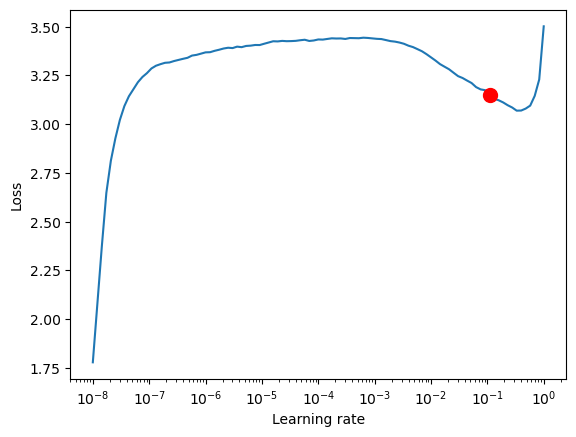

In [ ]:
embmlp_experiment_name = "embMLP-v2"

trainer = L.Trainer(
    devices="auto",  # (os.cpu_count() / 2)
    callbacks=[
        # EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
        ValPercentageEarlyStopping(
            monitor="val_loss", mode="min", patience=5, min_delta_percentage=0.01
        ),
        # ModelCheckpoint(
        #     monitor="val_loss",
        #     mode="min",
        #     save_top_k=1,
        #     every_n_epochs=5,
        #     enable_version_counter=False,
        #     dirpath=f"lightning_logs/checkpoints/{mlp_experiment_name}",
        #     filename=f"best_model_{mlp_experiment_name}",
        # ),
    ],
    logger=CSVLogger(
        save_dir=f"{config['lightning_exp_storage_directory']}/csv_logs/",
        name=embmlp_experiment_name,
    ),
    max_epochs=100,
    precision="bf16-mixed",
    default_root_dir=f"{config['lightning_exp_storage_directory']}",
)

# create a Tuner
tuner = Tuner(trainer)

# finds learning rate automatically, update hparams.lr to that learning rate
lr_finder = tuner.lr_find(lightningmodel, datamodule=dm)
fig = lr_finder.plot(suggest=True)
# fig.savefig("lr_suggest.pdf")
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)
# update hparams of the model
lightningmodel.learning_rate = new_lr

In [ ]:
# training
trainer.fit(
    model=lightningmodel,
    train_dataloaders=dm.train_dataloader(),
    val_dataloaders=dm.val_dataloader(),
)  # stage of the dataloader to use


  | Name      | Type                             | Params | Mode 
-----------------------------------------------------------------------
0 | model     | MulticlassTabularCatEmbeddingMLP | 3.6 M  | train
1 | train_acc | MulticlassF1Score                | 0      | train
2 | val_acc   | MulticlassF1Score                | 0      | train
3 | test_acc  | MulticlassF1Score                | 0      | train
-----------------------------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.205    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

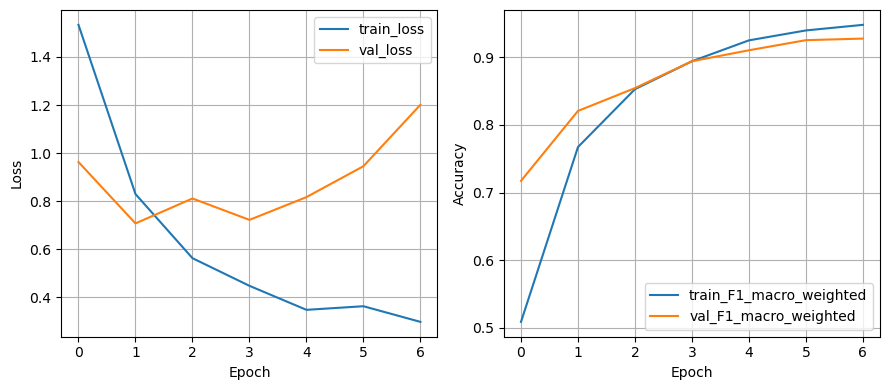

In [46]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

df_metrics = tl_utils.plot_training_metrics(metrics)

In [47]:
df_metrics.tail(10)

,epoch,step,train_F1_macro_weighted,train_loss,val_F1_macro_weighted,val_loss
0,0,469.333333,0.508554,1.533508,0.717249,0.962766
1,1,1292.789474,0.767340,0.829517,0.820769,0.707422
2,2,2121.111111,0.852923,0.562721,0.854550,0.811056
3,3,2944.473684,0.894324,0.447709,0.894288,0.722107
4,4,3792.684211,0.925221,0.347796,0.910543,0.816707
5,5,4621.000000,0.939912,0.362815,0.925500,0.945371
6,6,5444.368421,0.948166,0.297727,0.927840,1.200918


In [48]:
score = trainer.test(model=lightningmodel, dataloaders=dm.test_dataloader())

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.9285451173782349     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
score[0]["test_F1_macro_weighted"]

0.9285451173782349

In [ ]:
# make predictions on test data and evaluate
preds_y_test = torch.cat(trainer.predict(model=lightningmodel, dataloaders=dm.test_dataloader()))
# inverse transform to get back to original labels
preds_y_test = dm.label_encoder_target.inverse_transform(preds_y_test.reshape(-1, 1))
y_test = dm.label_encoder_target.inverse_transform(
    dm.test_dataset.get_dataframe.iloc[:, -1].values.reshape(-1, 1)
)
# calculate classification report
print(classification_report(y_test, preds_y_test))

Predicting: |          | 0/? [00:00<?, ?it/s]

                            precision    recall  f1-score   support

   Blister and Insert Card       0.96      0.96      0.96      1749
  Blister and sealed blist       0.99      0.96      0.97      1582
            Book packaging       1.00      0.20      0.33        20
Cardb. Sleeve w - w/o Shr.       0.62      0.65      0.64       135
  Cardboard hanger w/o bag       1.00      0.24      0.38        80
    Carton cover (Lid box)       0.59      0.88      0.71       130
   Carton tube with or w/o       0.00      0.00      0.00        20
                      Case       0.80      0.70      0.75        97
         Corrugated carton       0.98      0.89      0.93       774
        Countertop display       0.00      0.00      0.00        30
                  Envelope       0.94      0.80      0.86        59
          Fabric packaging       0.00      0.00      0.00        20
            Folding carton       0.91      0.93      0.92      1644
              Hanger/ Clip       0.97      0.99